In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from datetime import datetime
from math import sqrt, exp
from statistics import mean

from statsmodels.api import ProbPlot
from statsmodels.graphics import tsaplots
from statsmodels.stats.stattools import jarque_bera as jb
from statsmodels.stats.diagnostic import acorr_ljungbox as lb
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import kstest, boxcox, gaussian_kde, norm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import AutoARIMA

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from tstoolbox import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(rc = {"figure.figsize":(10,4), "axes.facecolor": "#eeeef4"})
my_palette = sns.color_palette(sns.diverging_palette(255,
                                                     133,
                                                     l=40,
                                                     n=4,
                                                     center="dark"))
sns.set_palette(my_palette)

In [3]:
ts_df = pd.read_csv('wolf_river.csv', sep = ';')
ts_df['index'] = pd.to_datetime(ts_df['month'])
ts_df.set_index('index', inplace = True)
ts_df.drop(["month"], axis = 1, inplace = True) # Serie como pd.DataFrame
ts = ts_df.iloc[:,0] # Serie como pd.Series

In [4]:
type(ts_df)

pandas.core.frame.DataFrame

In [5]:
type(ts)

pandas.core.series.Series

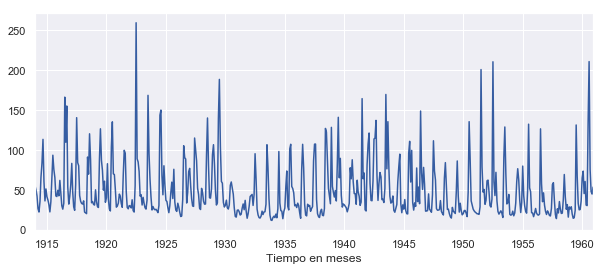

In [6]:
tsplot(ts)
plt.savefig("river.png", dpi = 400)
plt.show()

#### División temporal en período de modelización y período de predicción

In [7]:
train = ts_split(ts_df)[0] # Período de ajsute de modelos
test  = ts_split(ts)[1]    # Período de generación de predicciones

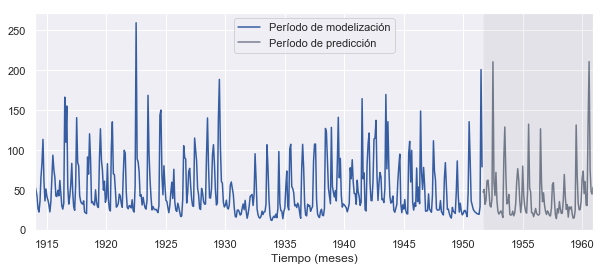

In [8]:
train_test_plot(train, test)
plt.savefig("river_split.png", dpi = 400)
plt.show()

#### Fechas destacables

In [9]:
start_date = train.index[0]
split_date = test.index[0]  # Primera observación a predecir
end_date   = test.index[-1]

### Métodos ingenuos

##### Método ingenuo simple

In [10]:
naive_forecast = naive(train, test)

In [11]:
print("Método ingenuo simple")
print("")
print("RMSE (test):   " + str(round(sqrt(mse(test, naive_forecast)), 2)))
print("MAE (test):    " + str(round(mae(test, naive_forecast), 2)))
print("sMAPE (test):  " + str(round(smape(test, naive_forecast), 2)))

Método ingenuo simple

RMSE (test):   49.56
MAE (test):    45.11
sMAPE (test):  79.4


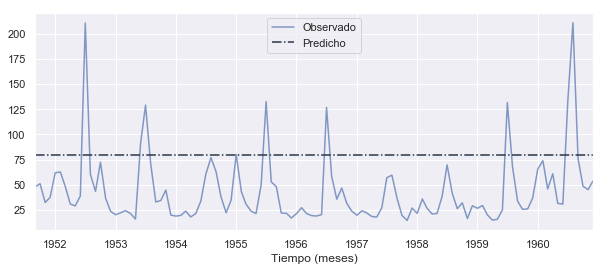

In [12]:
forecast_plot(test, naive_forecast)
plt.savefig("river_naive.png", dpi = 400)
plt.show()

##### Método ingenuo estacional

In [13]:
snaive_forecast = snaive(train, test)

In [14]:
print("Método ingenuo estacional")
print("")
print("RMSE (test):   " + str(round(sqrt(mse(test, snaive_forecast)), 2)))
print("MAE (test):    " + str(round(mae(test, snaive_forecast), 2)))
print("sMAPE (test):  " + str(round(smape(test, snaive_forecast), 2)))

Método ingenuo estacional

RMSE (test):   54.57
MAE (test):    29.2
sMAPE (test):  45.92


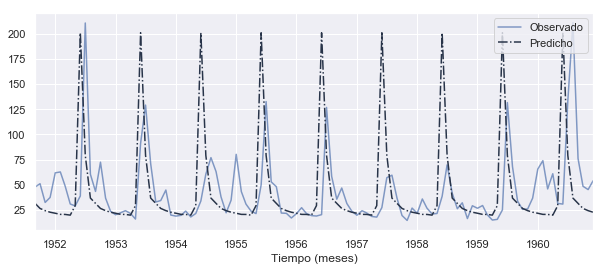

In [15]:
forecast_plot(test, snaive_forecast, leg_position=1)
plt.savefig("river_snaive.png", dpi = 400)
plt.show()

### No estacionariedad en varianza: Transformación de Box-Cox

In [16]:
boxcox_trans = boxcox(train)
bc_param = boxcox_trans[1][0]
bc_train = ((train**bc_param)-1)/bc_param

In [17]:
print("Transformación de Box-Cox")
print("")
print("Parámetro lambda de transformación: " + str(round(bc_param, 4)))

Transformación de Box-Cox

Parámetro lambda de transformación: -0.3807


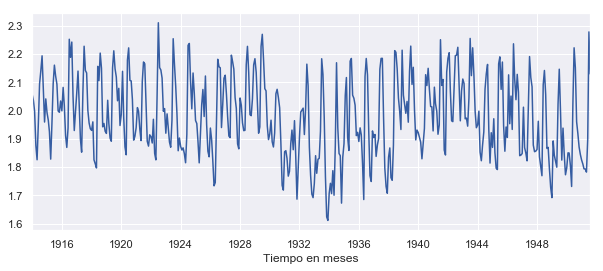

In [18]:
tsplot(bc_train)
plt.savefig("river_box.png", dpi = 400)
plt.show()

### Métodos de Suavizado Exponencial

##### Suavizado Exponencial Simple

In [19]:
ses = ExponentialSmoothing(bc_train)
ses_model = ses.fit()

ses_alpha = ses_model.params["smoothing_level"]
ses_aic = ses_model.aic

ses_fitted = ses_model.fittedvalues
ses_resid = (ses_model.resid -
             ses_model.resid.mean()) / ses_model.resid.std()
ses_jb_test = jb(ses_resid)
ses_lb_test = lb(ses_resid)

ses_forecast = ses_model.predict(split_date, end_date)
ses_box_forecast = (bc_param * ses_forecast + 1) ** (1 / bc_param)

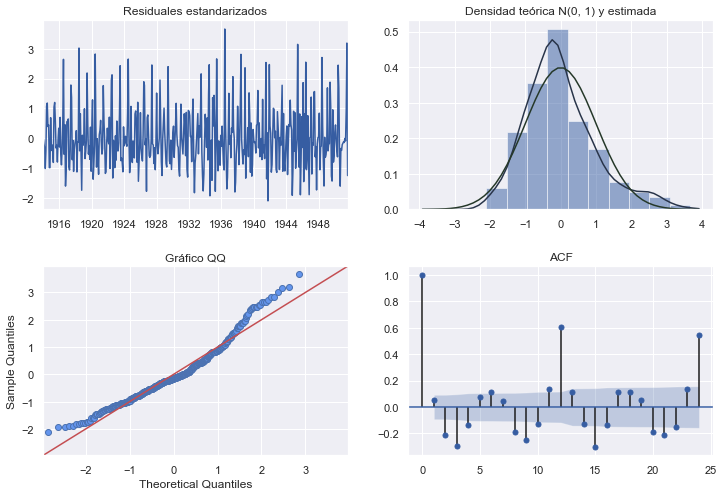

In [20]:
resid_diag(ses_resid)
plt.show()

In [21]:
print("Suavizado Exponencial Simple")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Parámetro alfa de suavizado: " + str(ses_alpha))
print("")
print("AIC: " + str(ses_aic))
print("Test de Jarque-Bera (p-valor): " 
      + str(round(ses_jb_test[1], 6)))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(round(ses_lb_test[1][6], 6)))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(round(ses_lb_test[1][12], 6)))
print("")
print("RMSE (test):   " + str(round(sqrt(mse(test, ses_box_forecast)), 2)))
print("MAE (test):    " + str(round(mae(test, ses_box_forecast), 2)))
print("sMAPE (test):  " + str(round(smape(test, ses_box_forecast), 2)))

Suavizado Exponencial Simple

Observaciones ajustadas: 452
Observaciones predichas: 112

Parámetro alfa de suavizado: 1.0

AIC: -1924.5128147975815
Test de Jarque-Bera (p-valor): 0.0
Test de Ljung-Box para k =  6 (p-valor): 0.0
Test de Ljung-Box para k = 12 (p-valor): 0.0

RMSE (test):   49.56
MAE (test):    45.11
sMAPE (test):  79.4


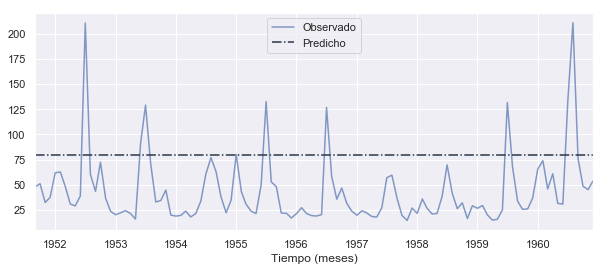

In [22]:
forecast_plot(test, ses_box_forecast)
plt.show()

##### Suavizado Exponencial Doble

In [23]:
hl = ExponentialSmoothing(bc_train, trend = "add")
hl_model = hl.fit()

hl_alpha = hl_model.params["smoothing_level"]
hl_beta = hl_model.params["smoothing_slope"]
hl_aic = hl_model.aic

hl_fitted = hl_model.fittedvalues
hl_resid = (hl_model.resid - hl_model.resid.mean()) / hl_model.resid.std()
hl_jb_test = jb(hl_resid)
hl_lb_test = lb(hl_resid)

hl_forecast = hl_model.predict(split_date, end_date)
hl_box_forecast = (bc_param * hl_forecast + 1) ** (1 / bc_param)

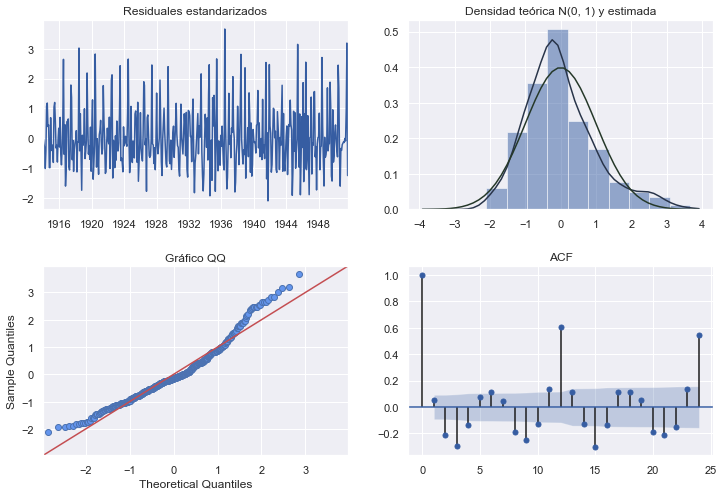

In [24]:
resid_diag(hl_resid)
plt.show()

In [25]:
print("Suavizado Exponencial Doble")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Parámetro alfa de suavizado: " + str(hl_alpha))
print("Parámetro beta de suavizado: " + str(hl_beta))
print("")
print("AIC: " + str(hl_aic))
print("Test de Jarque-Bera (p-valor): " + str(round(hl_jb_test[1], 6)))
print("Test de Ljung-Box para k =  6 (p-valor): " 
      + str(round(hl_lb_test[1][6], 6)))
print("Test de Ljung-Box para k = 12 (p-valor): " 
      + str(round(hl_lb_test[1][12], 6)))
print("")
print("RMSE (test):   " + str(round(sqrt(mse(test, hl_box_forecast)), 2)))
print("MAE (test):    " + str(round(mae(test, hl_box_forecast), 2)))
print("sMAPE (test):  " + str(round(smape(test, hl_box_forecast), 2)))

Suavizado Exponencial Doble

Observaciones ajustadas: 452
Observaciones predichas: 112

Parámetro alfa de suavizado: 1.0
Parámetro beta de suavizado: 0.0

AIC: -1920.5136536138625
Test de Jarque-Bera (p-valor): 0.0
Test de Ljung-Box para k =  6 (p-valor): 0.0
Test de Ljung-Box para k = 12 (p-valor): 0.0

RMSE (test):   52.5
MAE (test):    48.48
sMAPE (test):  82.59


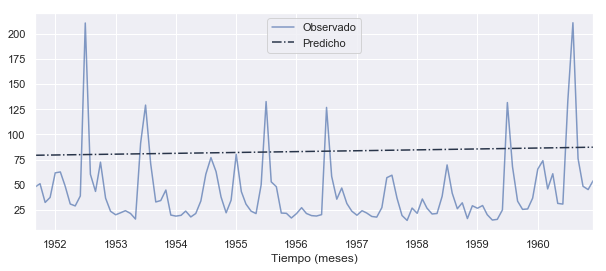

In [26]:
forecast_plot(test, hl_box_forecast)
plt.show()

##### Suavizado Exponencial Triple

In [27]:
hw = ExponentialSmoothing(bc_train, trend = "add",
                          seasonal = "add", seasonal_periods = 12)
hw_model = hw.fit()

hw_alpha = hw_model.params["smoothing_level"]
hw_beta = hw_model.params["smoothing_slope"]
hw_delta = hw_model.params["smoothing_seasonal"]
hw_aic = hw_model.aic

hw_fitted = hw_model.fittedvalues
hw_resid = (hw_model.resid - hw_model.resid.mean()) / hw_model.resid.std()
hw_jb_test = jb(hw_resid)
hw_lb_test = lb(hw_resid)

hw_forecast = hw_model.predict(split_date, end_date)
hw_box_forecast = (bc_param * hw_forecast + 1) ** (1 / bc_param)

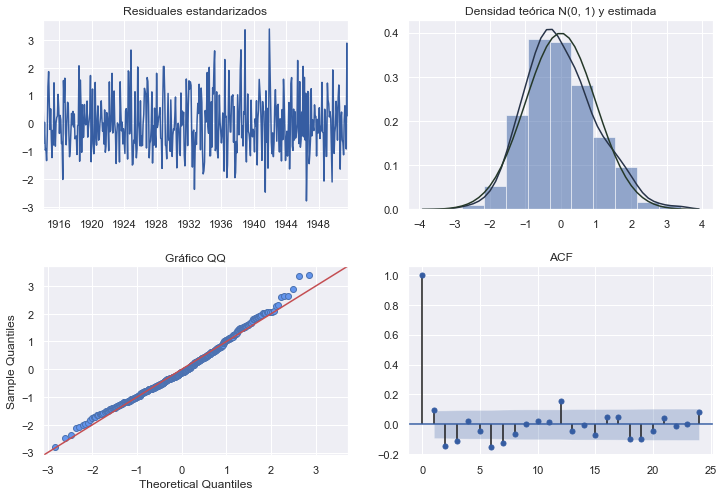

In [28]:
resid_diag(hw_resid)
plt.show()

In [29]:
print("Suavizado Exponencial Triple")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Parámetro alfa de suavizado: " + str(round(hw_alpha, 4)))
print("Parámetro beta de suavizado: " + str(round(hw_beta, 4)))
print("Parámetro delta de suavizado: " + str(round(hw_delta, 4)))
print("")
print("AIC: " + str(round(hw_aic, 2)))
print("Test de Jarque-Bera (p-valor): " + 
      str(round(hw_jb_test[1], 6)))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(round(hw_lb_test[1][6], 6)))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(round(hw_lb_test[1][12], 6)))
print("")
print("RMSE (test):   " + str(round(sqrt(mse(test, hw_box_forecast)), 2)))
print("MAE (test):    " + str(round(mae(test, hw_box_forecast), 2)))
print("sMAPE (test):  " + str(round(smape(test, hw_box_forecast), 2)))

Suavizado Exponencial Triple

Observaciones ajustadas: 452
Observaciones predichas: 112

Parámetro alfa de suavizado: 0.5461
Parámetro beta de suavizado: 0.0
Parámetro delta de suavizado: 0.0

AIC: -2292.11
Test de Jarque-Bera (p-valor): 0.001383
Test de Ljung-Box para k =  6 (p-valor): 3e-06
Test de Ljung-Box para k = 12 (p-valor): 1e-06

RMSE (test):   24.4
MAE (test):    16.84
sMAPE (test):  36.9


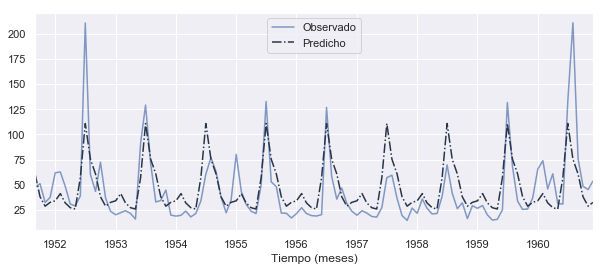

In [30]:
forecast_plot(test, hw_box_forecast)
plt.show()

### 2. Metodología Box-Jenkins

#### Estacionariedad en media en la estructura regular y/o estacional

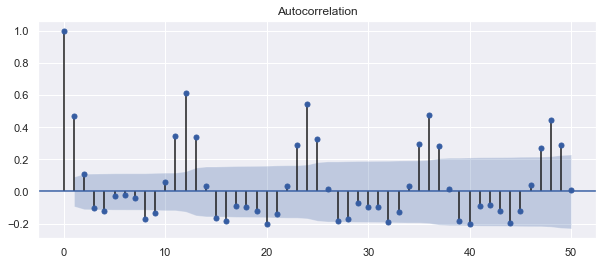

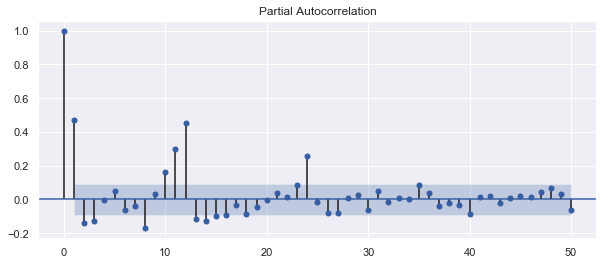

In [31]:
tsaplots.plot_acf(train, lags = 50)
tsaplots.plot_pacf(train, lags = 50)
plt.show()

#### Test de Canova-Hansen de existencia de raíz unitaria estacional

In [32]:
D = nsdiffs(train, m = 12, test = "ch")
print(D)

0


#### Opción 1. Estimación de la estacionalidad por variables dummy

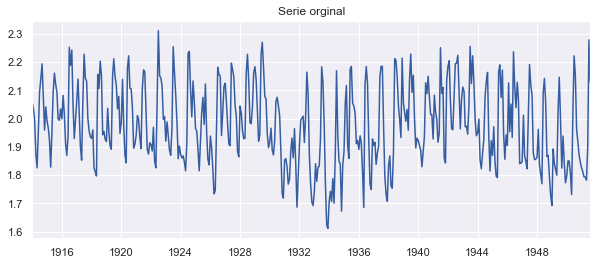

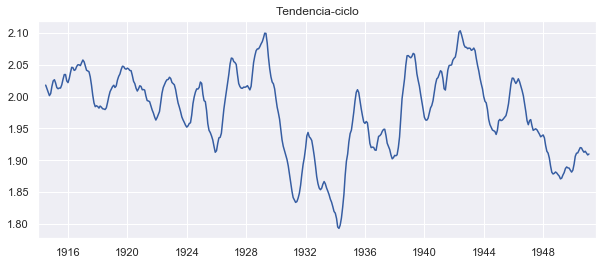

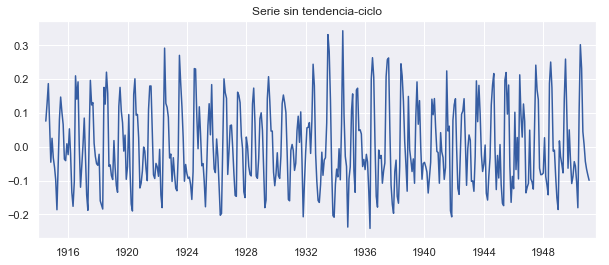

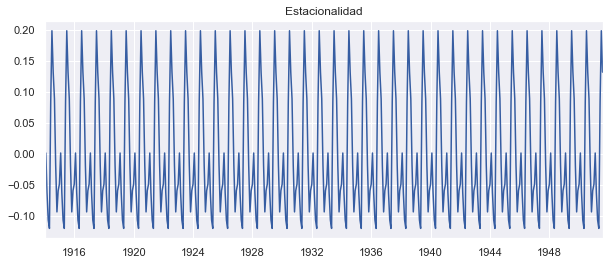

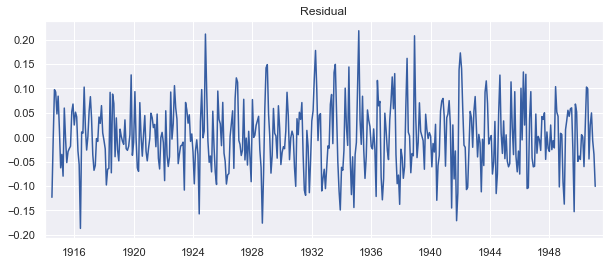

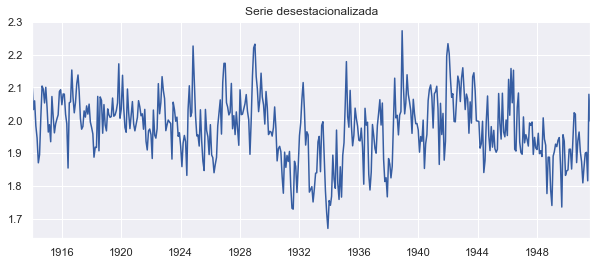

In [33]:
ts_components = seasonal_decompose(bc_train, "add")

bc_trend    = ts_components.trend
bc_seasonal = ts_components.seasonal
bc_residual = ts_components.resid

bc_deseas = bc_train - bc_seasonal
bc_demean = bc_train - bc_trend

plt.plot(bc_train)
plt.title("Serie orginal")
plt.xlim([train.index[0], train.index[-1]])
plt.show()
plt.plot(bc_trend)
plt.title("Tendencia-ciclo")
plt.xlim([train.index[0], train.index[-1]])
plt.show()
plt.plot(bc_demean)
plt.title("Serie sin tendencia-ciclo")
plt.xlim([train.index[0], train.index[-1]])
plt.show()
plt.plot(bc_seasonal)
plt.title("Estacionalidad")
plt.xlim([train.index[0], train.index[-1]])
plt.show()
plt.plot(bc_residual)
plt.title("Residual")
plt.xlim([train.index[0], train.index[-1]])
plt.show()
plt.plot(bc_deseas)
plt.title("Serie desestacionalizada")
plt.xlim([train.index[0], train.index[-1]])
plt.show()

##### Índices estacionales

In [34]:
months = ["Enero", "Febrero", "Marzo", "Abril",
         "Mayo", "Junio", "Julio", "Agosto",
         "Septiembre", "Octubre", "Noviembre", "Diciembre"]

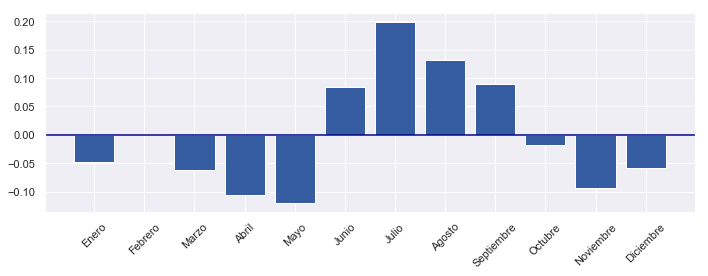

In [35]:
plt.xticks(rotation=45)
plt.axhline(0, color='darkblue')
plt.bar(months, height = bc_seasonal.iloc[:12,0].values)
plt.tight_layout()
plt.savefig("seasonal_index.png", dpi=400)
plt.show()

#### Predicción de la estacionalidad con el método ingenuo estacional

In [36]:
bc_seasonality_forecast = snaive(bc_seasonal, test)

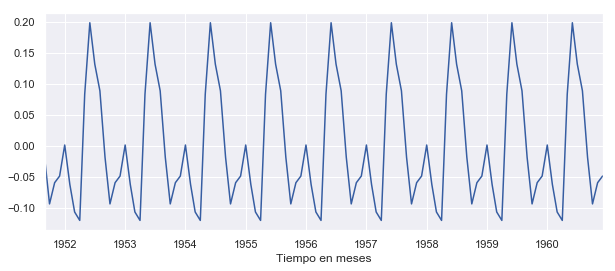

In [37]:
tsplot(bc_seasonality_forecast)
plt.show()

#### Modelización de la serie desestacionalizada

#### Test ADF y KPSS para determinar el tratamiento de la tendencia-ciclo

In [38]:
adf_test = stationarity_test(bc_deseas)[0]
kpss_test = stationarity_test(bc_deseas)[1]

print("RESULTADOS DEL TEST AUMENTADO DE DICKEY FULLER")
print("Estadístico de contraste: " + str(adf_test[0]))
print("P-valor: " + str(adf_test[1]))
print("")
print("RESULTADOS DEL TEST KPSS")
print("Estadístico de contraste: " + str(kpss_test[0]))
print("P-valor: " + str(kpss_test[1]))

RESULTADOS DEL TEST AUMENTADO DE DICKEY FULLER
Estadístico de contraste: -3.6635385092817327
P-valor: 0.004656249355488653

RESULTADOS DEL TEST KPSS
Estadístico de contraste: 0.34855555965899915
P-valor: 0.09932950014698312


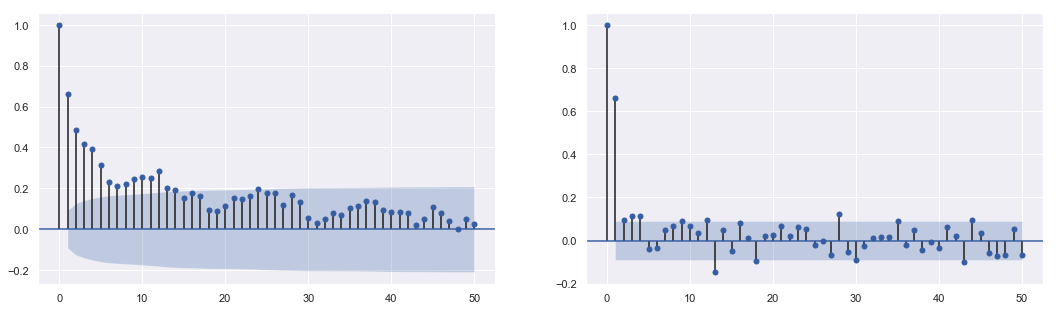

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

tsaplots.plot_acf(bc_deseas, lags = 50, title = "", ax=ax[0])
tsaplots.plot_pacf(bc_deseas, lags = 50, title = "", ax=ax[1])


plt.savefig("facs_deseas.png", dpi = 400)
plt.show()

In [40]:
bc_diff_deseas = bc_deseas.diff(1).iloc[1:]

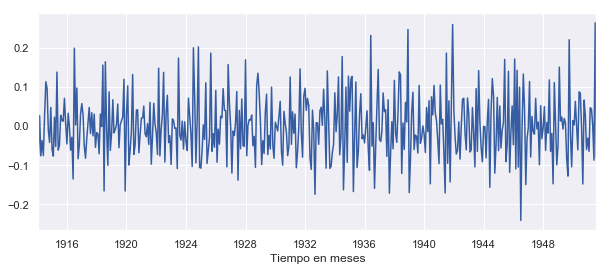

In [41]:
tsplot(bc_diff_deseas)

In [42]:
bc_diff_deseas_adf_test = stationarity_test(bc_diff_deseas)[0]
print("RESULTADOS DEL TEST AUMENTADO DE DICKEY FULLER")
print("Estadístico de contraste: " + str(bc_diff_deseas_adf_test[0]))
print("P-valor: " + str(bc_diff_deseas_adf_test[1]))

RESULTADOS DEL TEST AUMENTADO DE DICKEY FULLER
Estadístico de contraste: -7.858234299254451
P-valor: 5.3705132937936725e-12


##### Asumiendo estacionariedad en media en la estructura regualar

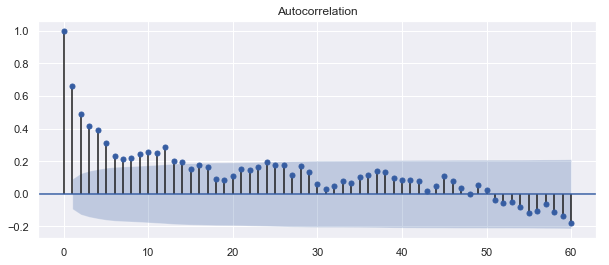

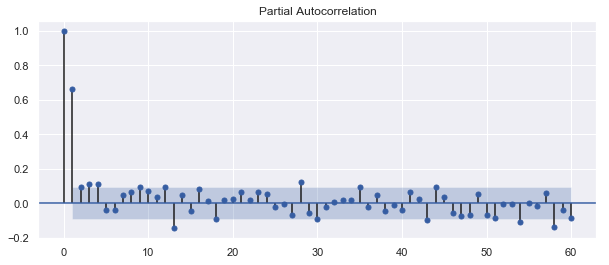

In [43]:
tsaplots.plot_acf(bc_deseas, lags = 60)
plt.show()
tsaplots.plot_pacf(bc_deseas, lags = 60)
plt.show()

##### Identificación de ordenes

Procesos candidatos a generar la serie desestacionalizada:
- **SARIMA (1, 0, 0) x (1, 0, 0)<sub>12</sub>**
- **SARIMA (2, 0, 0) x (1, 0, 0)<sub>12</sub>**
- **SARIMA (3, 0, 0) x (1, 0, 0)<sub>12</sub>**
- **SARIMA (1, 0, 0) x (1, 0, 0)<sub>12</sub>**

##### SARIMA (1, 0, 0) x (1, 0, 0)<sub>12</sub>

In [44]:
sarima1 = SARIMAX(bc_deseas, order = (1, 0, 0), seasonal_order = (1, 0, 0, 12))
sarima1_model = sarima1.fit()

sarima1_aic = sarima1_model.aic
sarima1_fitted = sarima1_model.fittedvalues
sarima1_resid = (sarima1_model.resid[12:] - 
                 sarima1_model.resid[12:].mean()) / sarima1_model.resid[12:].std()
sarima1_jb_test = jb(sarima1_resid)
sarima1_lb_test = lb(sarima1_resid)

sarima1_forecast = sarima1_model.predict(split_date, end_date)

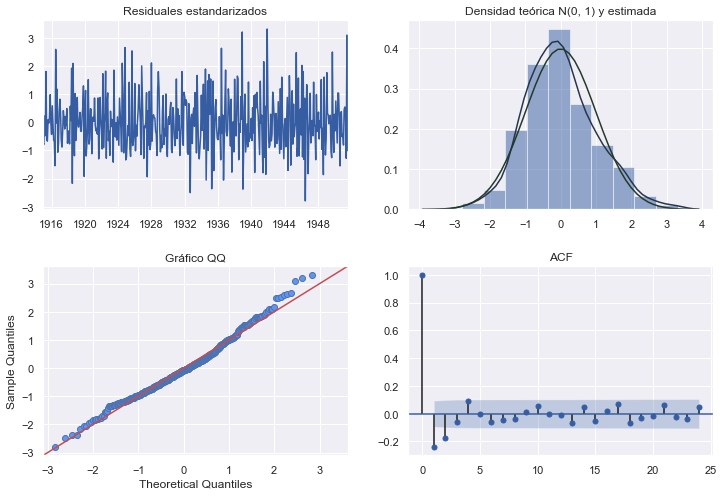

In [45]:
resid_diag(sarima1_resid)
plt.show()

In [46]:
print(sarima1_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 498.122
Date:                            Thu, 04 Jul 2019   AIC                           -990.244
Time:                                    18:45:01   BIC                           -977.903
Sample:                                01-01-1914   HQIC                          -985.381
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9989      0.002    412.426      0.000       0.994       1.004
ar.S.L12       0.1817      0.046   

##### Incluímos la componente estacional en la predicción

In [47]:
sarima1_seas_forecast = sarima1_forecast + bc_seasonality_forecast
sarima1_box_forecast = (bc_param * 
                        sarima1_seas_forecast + 1) ** (1 / bc_param)

In [48]:
print("SARIMA (1, 0, 0) x (1, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima1_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima1_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima1_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima1_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima1_box_forecast))))
print("MAE (test):  " + str(mae(test, sarima1_box_forecast)))
print("sMAPE (test):  " + str(smape(test, sarima1_box_forecast)))

SARIMA (1, 0, 0) x (1, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -990.2436857349406
Test de Jarque-Bera (p-valor): 0.000703689799407352
Test de Ljung-Box para k =  6 (p-valor): 9.348364038617179e-08
Test de Ljung-Box para k = 12 (p-valor): 3.02612164703319e-06

RMSE (test): 35.01214652563524
MAE (test):  21.426091309467676
sMAPE (test):  47.82440889998852


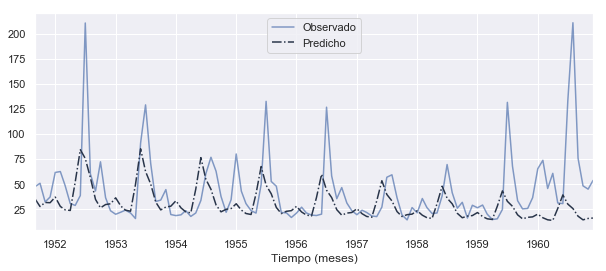

In [49]:
forecast_plot(test, sarima1_box_forecast)
plt.show()

##### SARIMA (2, 0, 0) x (1, 0, 0)<sub>12</sub>

In [50]:
sarima2 = SARIMAX(bc_deseas, order = (2, 0, 0), seasonal_order = (1, 0, 0, 12))
sarima2_model = sarima2.fit()

sarima2_aic = sarima2_model.aic
sarima2_fitted = sarima2_model.fittedvalues
sarima2_resid = (sarima2_model.resid[12:] - 
                 sarima2_model.resid[12:].mean()) / sarima2_model.resid[12:].std()
sarima2_jb_test = jb(sarima2_resid)
sarima2_lb_test = lb(sarima2_resid)

sarima2_forecast = sarima2_model.predict(split_date, end_date)

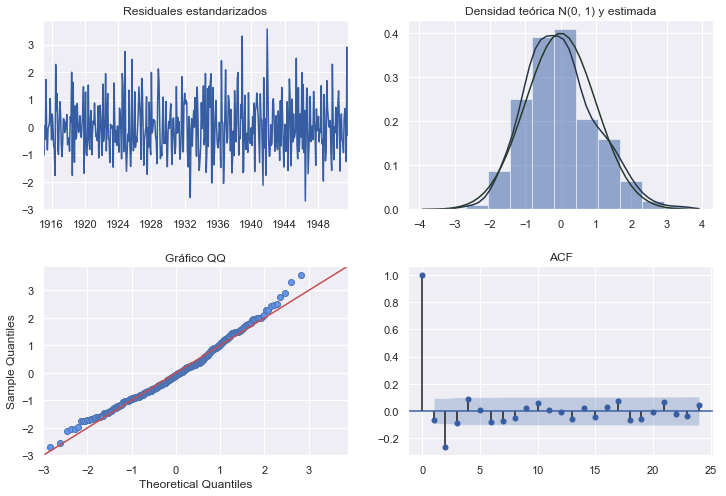

In [51]:
resid_diag(sarima2_resid)
plt.show()

In [52]:
print(sarima2_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 510.562
Date:                            Thu, 04 Jul 2019   AIC                          -1013.125
Time:                                    18:45:02   BIC                           -996.670
Sample:                                01-01-1914   HQIC                         -1006.641
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7665      0.045     17.075      0.000       0.679       0.855
ar.L2          0.2327      0.045   

##### Incluímos la componente estacional en la predicción

In [53]:
sarima2_seas_forecast = sarima2_forecast + bc_seasonality_forecast
sarima2_box_forecast = (bc_param *
                        sarima2_seas_forecast + 1) ** (1 / bc_param)

In [54]:
print("SARIMA (2, 0, 0) x (1, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima2_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima2_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima2_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima2_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima2_box_forecast))))
print("MAE (test):  " + str(mae(test, sarima2_box_forecast)))
print("sMAPE (test):  " + str(smape(test, sarima2_box_forecast)))

SARIMA (2, 0, 0) x (1, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1013.1247970732632
Test de Jarque-Bera (p-valor): 0.0005838844848180709
Test de Ljung-Box para k =  6 (p-valor): 1.7859542088064174e-07
Test de Ljung-Box para k = 12 (p-valor): 4.306284481982204e-06

RMSE (test): 33.36204984253718
MAE (test):  20.93837409539871
sMAPE (test):  43.256423677042946


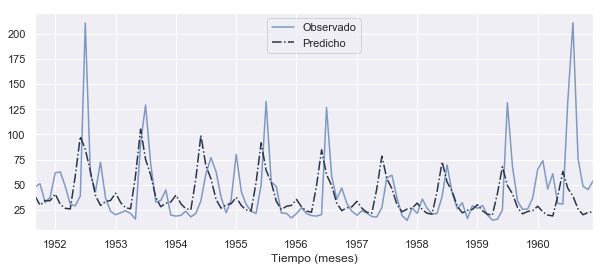

In [55]:
forecast_plot(test, sarima2_box_forecast)
plt.show()

##### SARIMA (3, 0, 0) x (1, 0, 0)<sub>12</sub>

In [56]:
sarima3 = SARIMAX(bc_deseas, order = (3, 0, 0), seasonal_order = (1, 0, 0, 12))
sarima3_model = sarima3.fit()

sarima3_aic = sarima3_model.aic
sarima3_fitted = sarima3_model.fittedvalues
sarima3_resid = (sarima3_model.resid[12:] - 
                 sarima3_model.resid[12:].mean()) / sarima3_model.resid[12:].std()
sarima3_jb_test = jb(sarima3_resid)
sarima3_lb_test = lb(sarima3_resid)

sarima3_forecast = sarima3_model.predict(split_date, end_date)

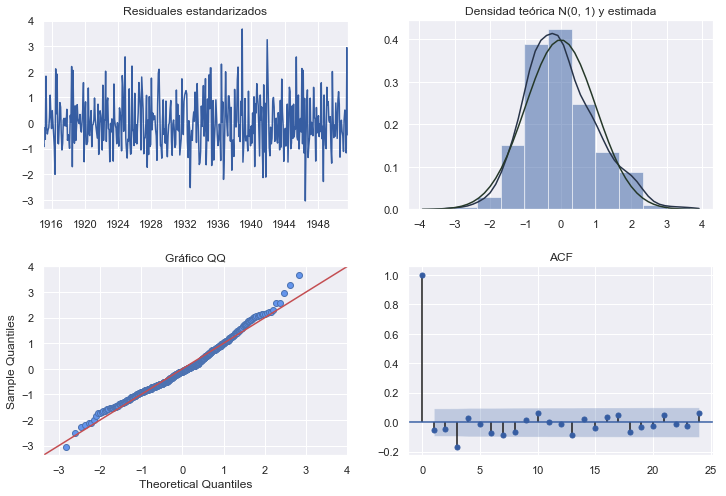

In [57]:
resid_diag(sarima3_resid)
plt.show()

In [58]:
print(sarima3_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 523.653
Date:                            Thu, 04 Jul 2019   AIC                          -1037.306
Time:                                    18:45:03   BIC                          -1016.738
Sample:                                01-01-1914   HQIC                         -1029.201
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7143      0.044     16.397      0.000       0.629       0.800
ar.L2          0.0443      0.060   

##### Incluímos la componente estacional en la predicción

In [59]:
sarima3_seas_forecast = sarima3_forecast + bc_seasonality_forecast
sarima3_box_forecast = (bc_param *
                        sarima3_seas_forecast + 1) ** (1 / bc_param)

In [60]:
print("SARIMA (3, 0, 0) x (1, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima3_aic))
print("Test de Jarque-Bera (p-valor): " +
      str(sarima3_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima3_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima3_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima3_box_forecast))))
print("MAE (test):  " + str(mae(test, sarima3_box_forecast)))
print("sMAPE (test):  " + str(smape(test, sarima3_box_forecast)))

SARIMA (3, 0, 0) x (1, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1037.3059844862905
Test de Jarque-Bera (p-valor): 0.0002395300271233465
Test de Ljung-Box para k =  6 (p-valor): 0.0030782005468447606
Test de Ljung-Box para k = 12 (p-valor): 0.007953950814358884

RMSE (test): 33.264475246335486
MAE (test):  20.640906133344604
sMAPE (test):  43.17662717478427


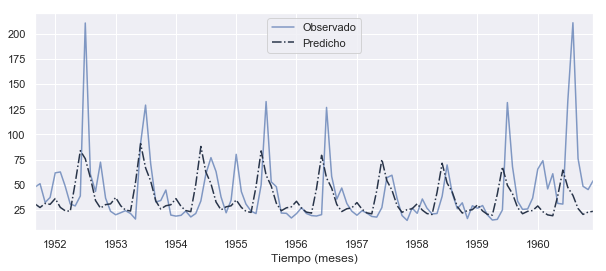

In [61]:
forecast_plot(test, sarima3_box_forecast)
plt.show()

##### SARIMA (1, 0, 0) x (2, 0, 0)<sub>12</sub>

In [62]:
sarima4 = SARIMAX(bc_deseas, order = (1, 0, 0), seasonal_order = (2, 0, 0, 12))
sarima4_model = sarima4.fit()

sarima4_aic = sarima4_model.aic
sarima4_fitted = sarima4_model.fittedvalues
sarima4_resid = (sarima4_model.resid[12:] -
                 sarima4_model.resid[12:].mean()) / sarima4_model.resid[12:].std()
sarima4_jb_test = jb(sarima4_resid)
sarima4_lb_test = lb(sarima4_resid)

sarima4_forecasted = sarima4_model.predict(split_date, end_date)

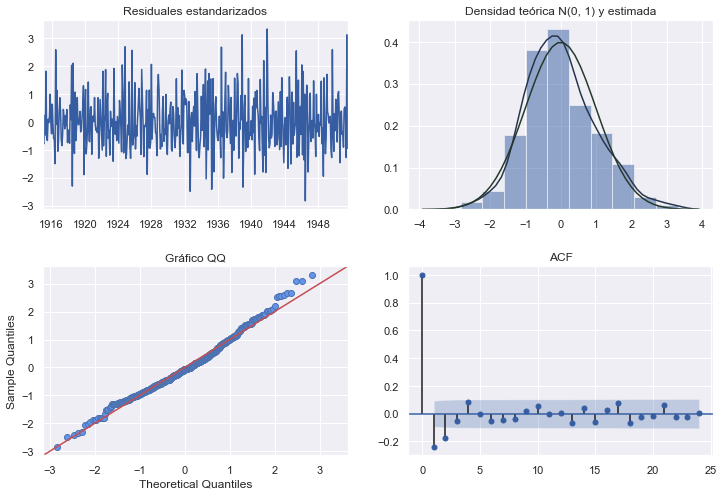

In [63]:
resid_diag(sarima4_resid)
plt.show()

In [64]:
print(sarima4_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 498.760
Date:                            Thu, 04 Jul 2019   AIC                           -989.521
Time:                                    18:45:05   BIC                           -973.066
Sample:                                01-01-1914   HQIC                          -983.036
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.003    395.285      0.000       0.994       1.004
ar.S.L12       0.1721      0.047   

##### Incluímos la componente estacional en la predicción

In [65]:
sarima4_seas_fore = sarima4_forecasted + bc_seasonality_forecast
sarima4_box_forecasted = (bc_param *
                          sarima4_seas_fore + 1) ** (1 / bc_param)

In [66]:
print("SARIMA (1, 0, 0) x (2, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima4_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima4_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima4_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima4_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima4_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima4_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima4_box_forecasted)))

SARIMA (1, 0, 0) x (2, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -989.5205192525689
Test de Jarque-Bera (p-valor): 0.0008326123323562449
Test de Ljung-Box para k =  6 (p-valor): 1.1234026340419993e-07
Test de Ljung-Box para k = 12 (p-valor): 3.231483301275644e-06

RMSE (test): 34.30400787973258
MAE (test):  20.96971443804415
sMAPE (test):  45.8176427427


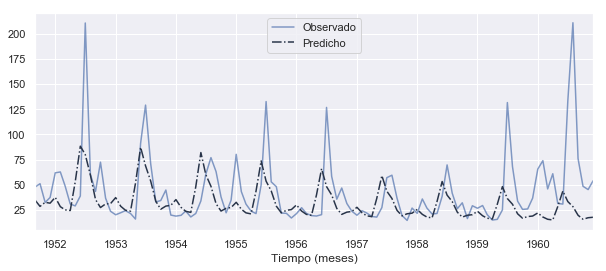

In [67]:
forecast_plot(test, sarima4_box_forecasted)
plt.show()

##### Considerando procesos integrados

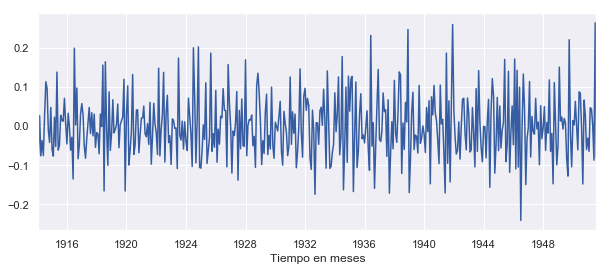

In [68]:
tsplot(bc_diff_deseas)
plt.savefig("diff_deseas.png")
plt.show()

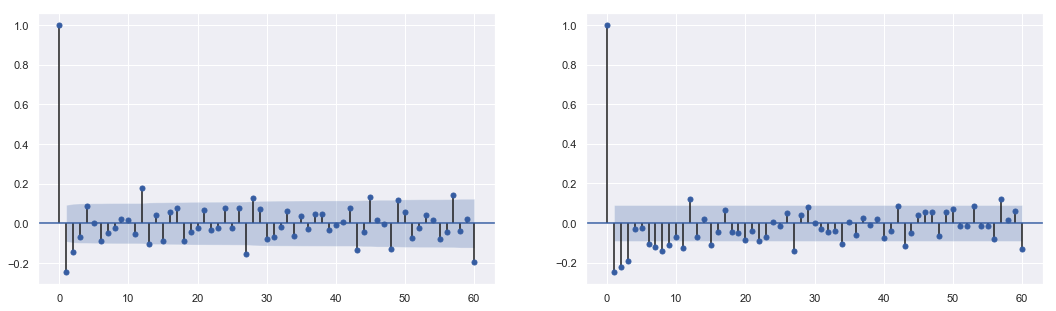

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

tsaplots.plot_acf(bc_diff_deseas, lags = 60, title = "", ax=ax[0])
tsaplots.plot_pacf(bc_diff_deseas, lags = 60, title = "", ax=ax[1])


plt.savefig("diff_deseas_facs.png", dpi = 400)
plt.show()

##### Identificación de ordenes

Procesos candidatos a generar la serie desestacionalizada:
- **SARIMA (0, 1, 2) x (1, 0, 0)<sub>12</sub>**
- **SARIMA (0, 1, 2) x (1, 0, 1)<sub>12</sub>**
- **SARIMA (0, 1, 2) x (2, 0, 0)<sub>12</sub>**

##### SARIMA (0, 1, 2) x (1, 0, 0)<sub>12</sub>

In [70]:
sarima5 = SARIMAX(bc_deseas, order = (0, 1, 2), seasonal_order = (1, 0, 0, 12))
sarima5_model = sarima5.fit()

sarima5_aic = sarima5_model.aic
sarima5_fitted = sarima5_model.fittedvalues
sarima5_resid = (sarima5_model.resid[12:] - 
                 sarima5_model.resid[12:].mean()) / sarima5_model.resid[12:].std()
sarima5_jb_test = jb(sarima5_resid)
sarima5_lb_test = lb(sarima5_resid)

sarima5_forecasted = sarima5_model.predict(split_date, end_date)

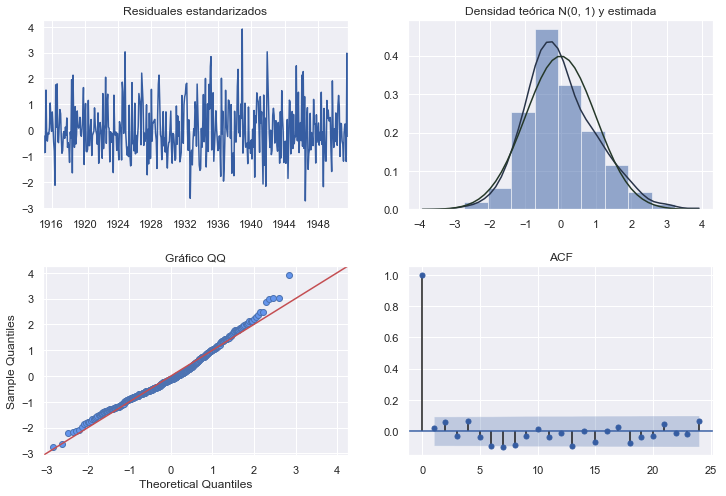

In [71]:
resid_diag(sarima5_resid)
plt.show()

In [72]:
print(sarima5_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(0, 1, 2)x(1, 0, 0, 12)   Log Likelihood                 536.624
Date:                            Thu, 04 Jul 2019   AIC                          -1065.247
Time:                                    18:45:07   BIC                          -1048.801
Sample:                                01-01-1914   HQIC                         -1058.766
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3946      0.042     -9.307      0.000      -0.478      -0.312
ma.L2         -0.2621      0.048   

##### Incluímos la componente estacional en la predicción

In [73]:
sarima5_seas_fore = sarima5_forecasted + bc_seasonality_forecast
sarima5_box_forecasted = (bc_param * sarima5_seas_fore + 1) ** (1 / bc_param)

In [74]:
print("SARIMA (0, 1, 2) x (1, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima5_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima5_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima5_lb_test[1][6]))
print("   Test de Ljung-Box para k = 12 (p-valor): " + 
      str(sarima5_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima5_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima5_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima5_box_forecasted)))

SARIMA (0, 1, 2) x (1, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1065.247025938098
Test de Jarque-Bera (p-valor): 4.899060158882278e-06
Test de Ljung-Box para k =  6 (p-valor): 0.06930557174720219
   Test de Ljung-Box para k = 12 (p-valor): 0.0567054705610174

RMSE (test): 33.22208969056615
MAE (test):  20.90303492438331
sMAPE (test):  43.176709437271505


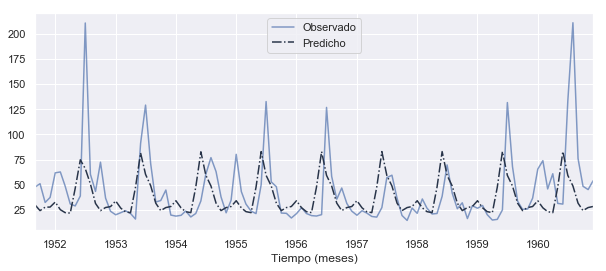

In [75]:
forecast_plot(test, sarima5_box_forecasted)
plt.show()

##### SARIMA (0, 1, 2) x (1, 0, 1)<sub>12</sub>

In [76]:
sarima6 = SARIMAX(bc_deseas, order = (0, 1, 2), seasonal_order = (1, 0, 1, 12))
sarima6_model = sarima6.fit()

sarima6_aic = sarima6_model.aic
sarima6_fitted = sarima6_model.fittedvalues
sarima6_resid = (sarima6_model.resid[12:] -
                 sarima6_model.resid[12:].mean()) / sarima6_model.resid[12:].std()
sarima6_jb_test = jb(sarima6_resid)
sarima6_lb_test = lb(sarima6_resid)

sarima6_forecasted = sarima6_model.predict(split_date, end_date)

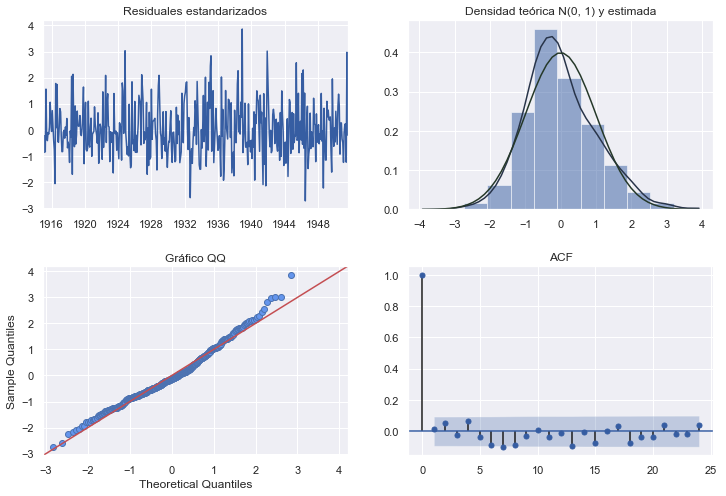

In [77]:
resid_diag(sarima6_resid)
plt.show()

In [78]:
print(sarima6_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                 537.410
Date:                            Thu, 04 Jul 2019   AIC                          -1064.820
Time:                                    18:45:08   BIC                          -1044.263
Sample:                                01-01-1914   HQIC                         -1056.719
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3958      0.043     -9.293      0.000      -0.479      -0.312
ma.L2         -0.2629      0.048   

##### Incluímos la componente estacional en la predicción

In [79]:
sarima6_seas_fore = sarima6_forecasted + bc_seasonality_forecast
sarima6_box_forecasted = (bc_param *
                          sarima6_seas_fore + 1) ** (1 / bc_param)

In [80]:
print("SARIMA (0, 1, 2) x (1, 0, 1) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima6_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima6_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima6_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima6_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima6_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima6_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima6_box_forecasted)))

SARIMA (0, 1, 2) x (1, 0, 1) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1064.8202474740951
Test de Jarque-Bera (p-valor): 7.840339372635264e-06
Test de Ljung-Box para k =  6 (p-valor): 0.09660711986874868
Test de Ljung-Box para k = 12 (p-valor): 0.0715205434558047

RMSE (test): 33.097596059360754
MAE (test):  20.862229508696394
sMAPE (test):  43.08602581853967


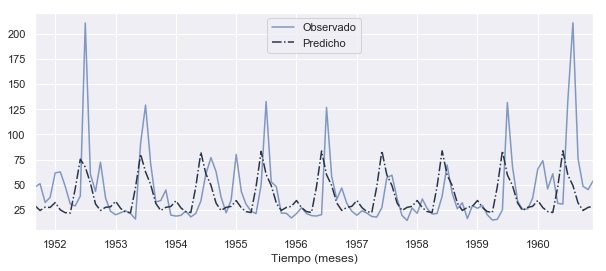

In [81]:
forecast_plot(test, sarima6_box_forecasted)
plt.show()

##### SARIMA (0, 1, 2) x (2, 0, 0)<sub>12</sub>

In [82]:
sarima7 = SARIMAX(bc_deseas, order = (0, 1, 2), seasonal_order = (2, 0, 0, 12))
sarima7_model = sarima7.fit()

sarima7_aic = sarima7_model.aic
sarima7_fitted = sarima7_model.fittedvalues
sarima7_resid = (sarima7_model.resid[12:] -
                 sarima7_model.resid[12:].mean()) / sarima7_model.resid[12:].std()
sarima7_jb_test = jb(sarima7_resid)
sarima7_lb_test = lb(sarima7_resid)

sarima7_forecasted = sarima7_model.predict(split_date, end_date)

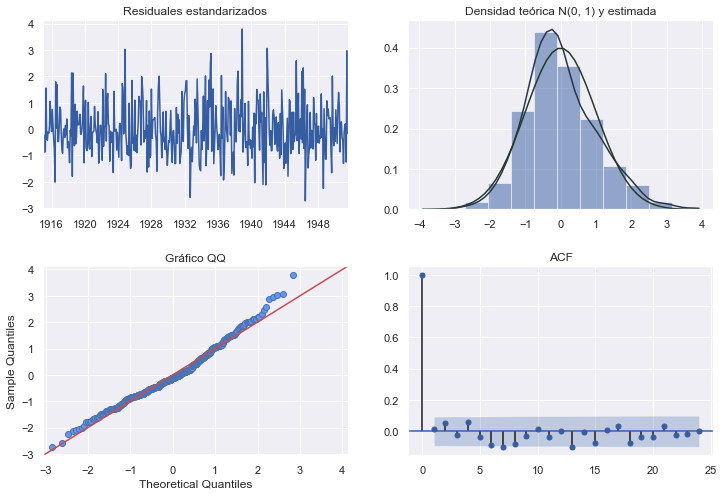

In [83]:
resid_diag(sarima7_resid)
plt.show()

In [84]:
print(sarima7_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(0, 1, 2)x(2, 0, 0, 12)   Log Likelihood                 538.021
Date:                            Thu, 04 Jul 2019   AIC                          -1066.042
Time:                                    18:45:09   BIC                          -1045.484
Sample:                                01-01-1914   HQIC                         -1057.940
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3965      0.042     -9.452      0.000      -0.479      -0.314
ma.L2         -0.2650      0.047   

##### Incluímos la componente estacional en la predicción

In [85]:
sarima7_seas_fore = sarima7_forecasted + bc_seasonality_forecast
sarima7_box_forecasted = (bc_param * 
                          sarima7_seas_fore + 1) ** (1 / bc_param)

In [86]:
print("SARIMA (0, 1, 2) x (2, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima7_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima7_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima7_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima7_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima7_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima7_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima7_box_forecasted)))

SARIMA (0, 1, 2) x (2, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1066.0415922868567
Test de Jarque-Bera (p-valor): 1.0860050176790743e-05
Test de Ljung-Box para k =  6 (p-valor): 0.11830845647215742
Test de Ljung-Box para k = 12 (p-valor): 0.09063065320021838

RMSE (test): 33.0379053381173
MAE (test):  20.871418150460133
sMAPE (test):  43.03383094851058


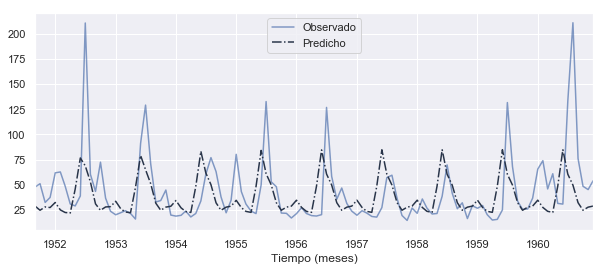

In [87]:
forecast_plot(test, sarima7_box_forecasted)
plt.show()

#### Autoarima

In [88]:
auto = auto_arima(bc_deseas, m=12, seasonal=True)
auto

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [89]:
autosarima1 = SARIMAX(bc_deseas, order = (1, 1, 1), seasonal_order = (1, 0, 0, 12))
autosarima1_model = autosarima1.fit()

autosarima1_aic = autosarima1_model.aic
autosarima1_fitted = autosarima1_model.fittedvalues
autosarima1_resid = (autosarima1_model.resid[12:] -
                     autosarima1_model.resid[12:].mean()) / autosarima1_model.resid[12:].std()
autosarima1_jb_test = jb(autosarima1_resid)
autosarima1_lb_test = lb(autosarima1_resid)

autosarima1_forecasted = autosarima1_model.predict(split_date, end_date)

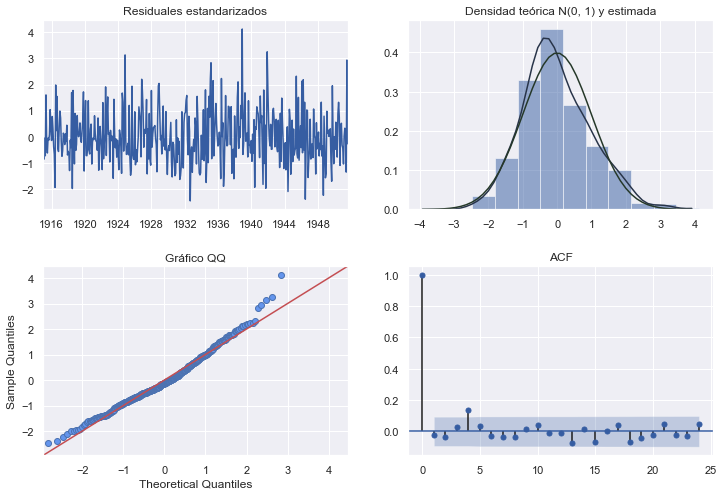

In [90]:
resid_diag(autosarima1_resid)
plt.show()

In [91]:
print(autosarima1_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood                 544.272
Date:                            Thu, 04 Jul 2019   AIC                          -1080.545
Time:                                    18:45:37   BIC                          -1064.099
Sample:                                01-01-1914   HQIC                         -1074.064
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5705      0.043     13.176      0.000       0.486       0.655
ma.L1         -0.9548      0.017   

#### Incluímos la componente estacional en la predicción

In [92]:
autosarima1_seas_fore = autosarima1_forecasted + bc_seasonality_forecast
autosarima1_box_forecasted = (bc_param * autosarima1_seas_fore + 1) ** (1 / bc_param)

In [93]:
print("SARIMA (1, 1, 1) x (2, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(autosarima1_aic))
print("Test de Jarque-Bera (p-valor): " + str(autosarima1_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(autosarima1_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(autosarima1_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, autosarima1_box_forecasted))))
print("MAE (test):  " + str(mae(test, autosarima1_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, autosarima1_box_forecasted)))

SARIMA (1, 1, 1) x (2, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1080.5448933279936
Test de Jarque-Bera (p-valor): 1.7693001979751832e-06
Test de Ljung-Box para k =  6 (p-valor): 0.15311810790555627
Test de Ljung-Box para k = 12 (p-valor): 0.3333204025803236

RMSE (test): 33.451003456851836
MAE (test):  20.846279715383275
sMAPE (test):  43.5275472737031


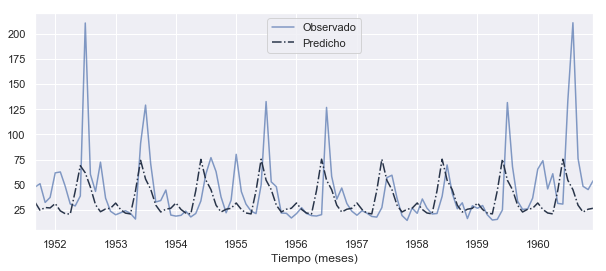

In [94]:
forecast_plot(test, autosarima1_box_forecasted)
plt.show()

Procesos finales candidatos a generar la serie desestacionalizada:
- **SARIMA (0, 1, 2) x (1, 0, 0)<sub>12</sub>**
- **SARIMA (1, 1, 1) x (1, 0, 0)<sub>12</sub>**

##### SARIMA (0, 1, 2) x (1, 0, 0)<sub>12</sub>

Véase `sarima5`

##### SARIMA (1, 1, 1) x (1, 0, 0)<sub>12</sub>

In [95]:
sarima8 = SARIMAX(bc_deseas, order = (1, 1, 1), seasonal_order = (1, 0, 0, 12))
sarima8_model = sarima8.fit()

sarima8_aic = sarima8_model.aic
sarima8_fitted = sarima8_model.fittedvalues
sarima8_resid = (sarima8_model.resid[12:] -
                 sarima8_model.resid[12:].mean()) / sarima8_model.resid[12:].std()
sarima8_jb_test = jb(sarima8_resid)
sarima8_lb_test = lb(sarima8_resid)

sarima8_forecasted = sarima8_model.predict(split_date, end_date)

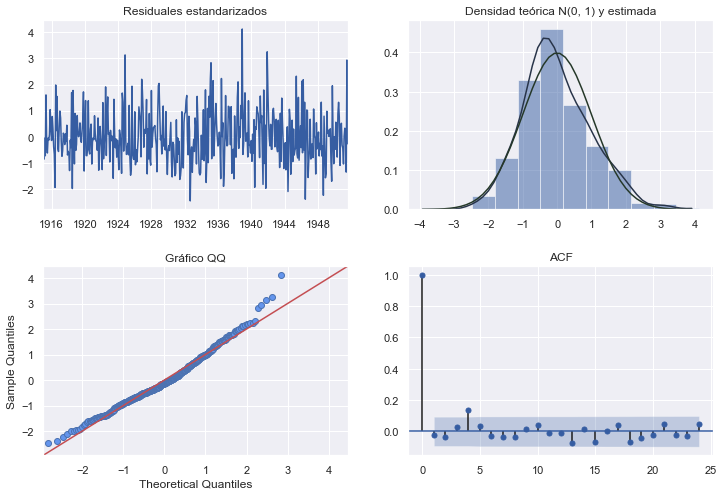

In [96]:
resid_diag(sarima8_resid)
plt.show()

In [97]:
print(sarima8_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood                 544.272
Date:                            Thu, 04 Jul 2019   AIC                          -1080.545
Time:                                    18:45:38   BIC                          -1064.099
Sample:                                01-01-1914   HQIC                         -1074.064
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5705      0.043     13.176      0.000       0.486       0.655
ma.L1         -0.9548      0.017   

##### Incluímos la componente estacional en la predicción

In [98]:
sarima8_seas_fore = sarima8_forecasted + bc_seasonality_forecast
sarima8_box_forecasted = (bc_param *
                          sarima8_seas_fore + 1) ** (1 / bc_param)

In [99]:
print("SARIMA (1, 1, 1) x (1, 0, 0) (serie desestacionalizada)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima8_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima8_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(sarima8_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(sarima8_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima8_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima8_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima8_box_forecasted)))

SARIMA (1, 1, 1) x (1, 0, 0) (serie desestacionalizada)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1080.5448933279936
Test de Jarque-Bera (p-valor): 1.7693001979751832e-06
Test de Ljung-Box para k =  6 (p-valor): 0.15311810790555627
Test de Ljung-Box para k = 12 (p-valor): 0.3333204025803236

RMSE (test): 33.451003456851836
MAE (test):  20.846279715383275
sMAPE (test):  43.5275472737031


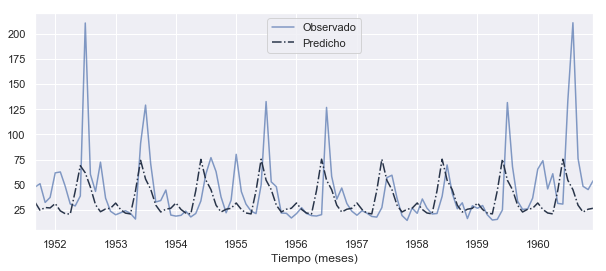

In [100]:
forecast_plot(test, sarima8_box_forecasted)
plt.show()

#### Opción 2. Modelo SARIMA.

#### Test ADF y KPSS para determinar el tratamiento de la tendencia-ciclo

In [101]:
adf_test = stationarity_test(bc_train)[0]
kpss_test = stationarity_test(bc_train)[1]

print("RESULTADOS DEL TEST AUMENTADO DE DICKEY FULLER")
print("Estadístico de contraste: " + str(adf_test[0]))
print("P-valor: " + str(adf_test[1]))
print("")
print("RESULTADOS DEL TEST KPSS")
print("Estadístico de contraste: " + str(kpss_test[0]))
print("P-valor: " + str(kpss_test[1]))

RESULTADOS DEL TEST AUMENTADO DE DICKEY FULLER
Estadístico de contraste: -3.812926799047772
P-valor: 0.0027777917233248674

RESULTADOS DEL TEST KPSS
Estadístico de contraste: 0.31804791289067974
P-valor: 0.1


In [102]:
diff_bc_train = bc_train.diff(1).iloc[1:]

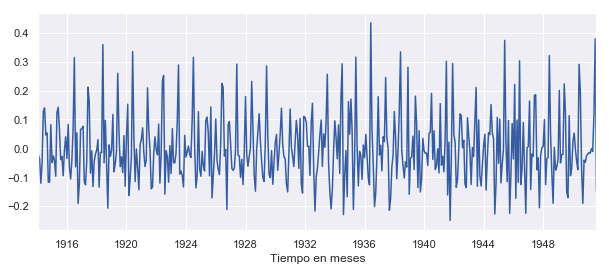

In [103]:
tsplot(diff_bc_train)

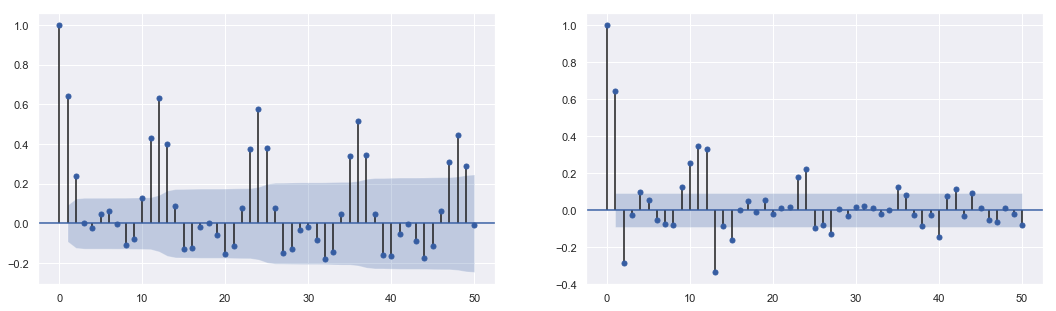

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

tsaplots.plot_acf(bc_train, lags = 50, title = "", ax=ax[0])
tsaplots.plot_pacf(bc_train, lags = 50, title = "", ax=ax[1])


plt.savefig("facs.png", dpi = 400)
plt.show()

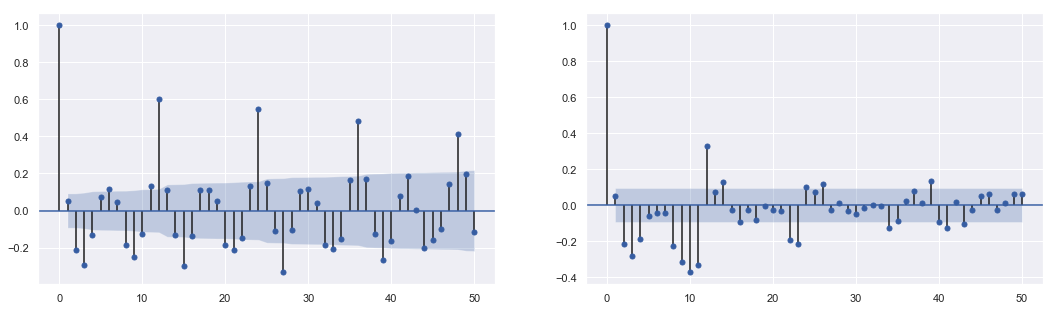

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

tsaplots.plot_acf(diff_bc_train, lags = 50, title = "", ax=ax[0])
tsaplots.plot_pacf(diff_bc_train, lags = 50, title = "", ax=ax[1])


plt.savefig("facs_diff.png", dpi = 400)
plt.show()

##### Identificación de ordenes

Procesos candidatos a generar la serie:
- **SARIMA (2, 0, 0) x (2, 0, 0)<sub>12</sub>**
- **SARIMA (1, 0, 1) x (2, 0, 0)<sub>12</sub>**
- **SARIMA (1, 0, 2) x (2, 0, 0)<sub>12</sub>**
- **SARIMA (3, 1, 0) x (2, 0, 0)<sub>12</sub>**
- **SARIMA (2, 1, 2) x (2, 0, 0)<sub>12</sub>**

**SARIMA (2, 0, 0) x (2, 0, 0)<sub>12</sub>**

In [106]:
sarima9 = SARIMAX(bc_train, order = (2, 0, 0), seasonal_order = (2, 0, 0, 12))
sarima9_model = sarima9.fit()

sarima9_aic = sarima9_model.aic
sarima9_fitted = sarima9_model.fittedvalues
sarima9_resid = (sarima9_model.resid[12:] -
                 sarima9_model.resid[12:].mean()) / sarima9_model.resid[12:].std()
sarima9_jb_test = jb(sarima9_resid)
sarima9_lb_test = lb(sarima9_resid)

sarima9_forecasted = sarima9_model.predict(split_date, end_date)
sarima9_box_forecasted = (bc_param * sarima9_forecasted + 1) ** (1 / bc_param)

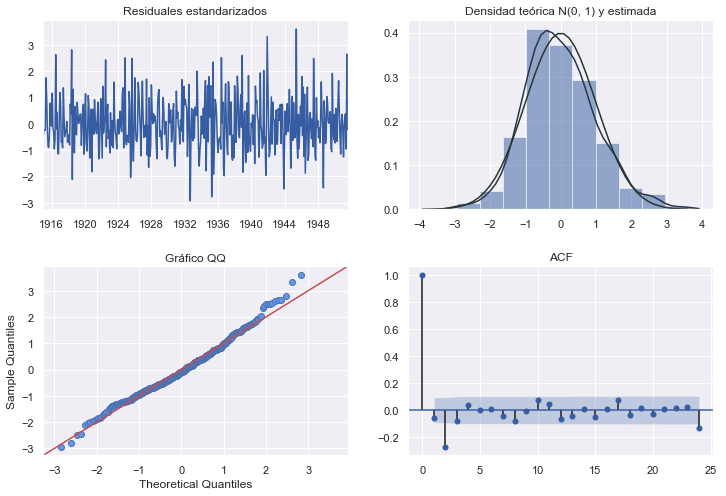

In [107]:
resid_diag(sarima9_resid)
plt.show()

In [108]:
print(sarima9_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 456.353
Date:                            Thu, 04 Jul 2019   AIC                           -902.707
Time:                                    18:45:42   BIC                           -882.138
Sample:                                01-01-1914   HQIC                          -894.601
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8028      0.049     16.306      0.000       0.706       0.899
ar.L2          0.1824      0.049   

In [109]:
print("SARIMA (2, 0, 0) x (2, 0, 0)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima9_aic))
print("Test de Jarque-Bera (p-valor): " +
      str(sarima9_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima9_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima9_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima9_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima9_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima9_box_forecasted)))

SARIMA (2, 0, 0) x (2, 0, 0)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -902.7066634500046
Test de Jarque-Bera (p-valor): 0.00035697719434374587
Test de Ljung-Box para k =  6 (p-valor): 2.089838109582137e-06
Test de Ljung-Box para k = 12 (p-valor): 6.379352048463386e-06

RMSE (test): 40.02521988513189
MAE (test):  25.897865650314316
sMAPE (test):  79.37610123282874


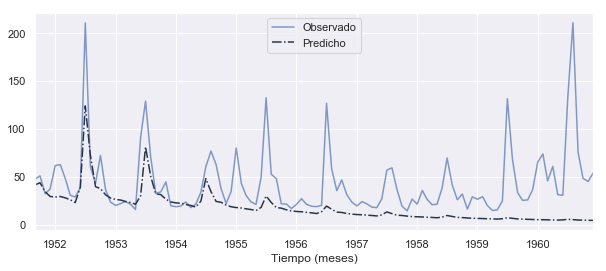

In [110]:
forecast_plot(test, sarima9_box_forecasted)
plt.show()

**SARIMA (1, 0, 1) x (2, 0, 0)<sub>12</sub>**

In [111]:
sarima10 = SARIMAX(bc_train, order = (1, 0, 1), seasonal_order = (2, 0, 0, 12))
sarima10_model = sarima10.fit()

sarima10_aic = sarima10_model.aic
sarima10_fitted = sarima10_model.fittedvalues
sarima10_resid = (sarima10_model.resid[12:] - 
                  sarima10_model.resid[12:].mean()) / sarima10_model.resid[12:].std()
sarima10_jb_test = jb(sarima10_resid)
sarima10_lb_test = lb(sarima10_resid)

sarima10_forecasted = sarima10_model.predict(split_date, end_date)
sarima10_box_forecasted = (bc_param * sarima10_forecasted + 1) ** (1 / bc_param)

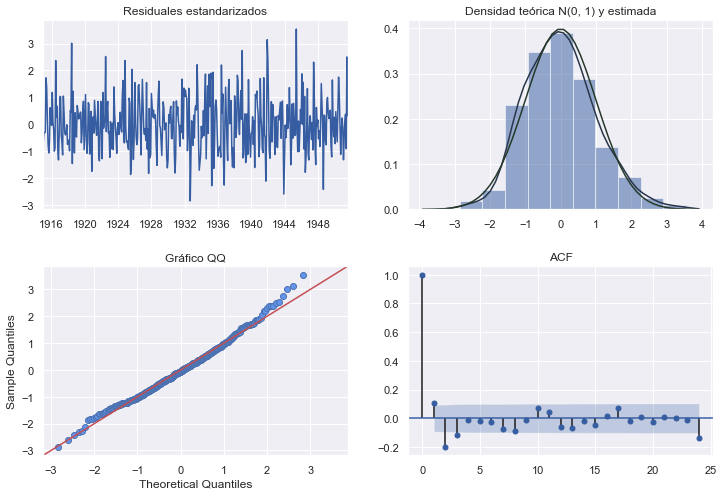

In [112]:
resid_diag(sarima10_resid)
plt.show()

In [113]:
print(sarima10_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(1, 0, 1)x(2, 0, 0, 12)   Log Likelihood                 464.686
Date:                            Thu, 04 Jul 2019   AIC                           -919.373
Time:                                    18:45:44   BIC                           -898.804
Sample:                                01-01-1914   HQIC                          -911.268
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9977      0.004    223.033      0.000       0.989       1.006
ma.L1         -0.4223      0.042   

In [114]:
print("SARIMA (1, 0, 1) x (2, 0, 0)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima10_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima10_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(sarima10_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima10_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima10_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima10_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima10_box_forecasted)))

SARIMA (1, 0, 1) x (2, 0, 0)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -919.3728280518599
Test de Jarque-Bera (p-valor): 0.005843389176126087
Test de Ljung-Box para k =  6 (p-valor): 5.763337363937166e-05
Test de Ljung-Box para k = 12 (p-valor): 7.224410996546479e-05

RMSE (test): 27.449553412296037
MAE (test):  17.665500442180765
sMAPE (test):  39.854219835874


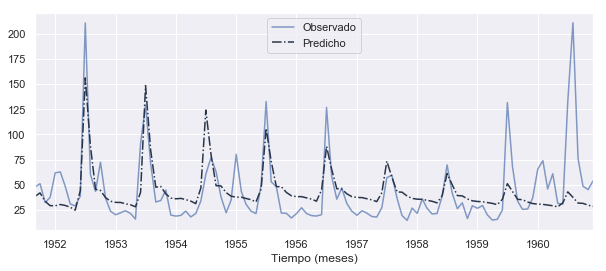

In [115]:
forecast_plot(test, sarima10_box_forecasted)
plt.show()

**SARIMA (1, 0, 2) x (2, 0, 0)<sub>12</sub>**

In [116]:
sarima11 = SARIMAX(bc_train, order = (1, 0, 2), seasonal_order = (2, 0, 0, 12))
sarima11_model = sarima11.fit()

sarima11_aic = sarima11_model.aic
sarima11_fitted = sarima11_model.fittedvalues
sarima11_resid = (sarima11_model.resid[12:] - 
                  sarima11_model.resid[12:].mean()) / sarima11_model.resid[12:].std()
sarima11_jb_test = jb(sarima11_resid)
sarima11_lb_test = lb(sarima11_resid)

sarima11_forecasted = sarima11_model.predict(split_date, end_date)
sarima11_box_forecasted = (bc_param * sarima11_forecasted + 1) ** (1 / bc_param)

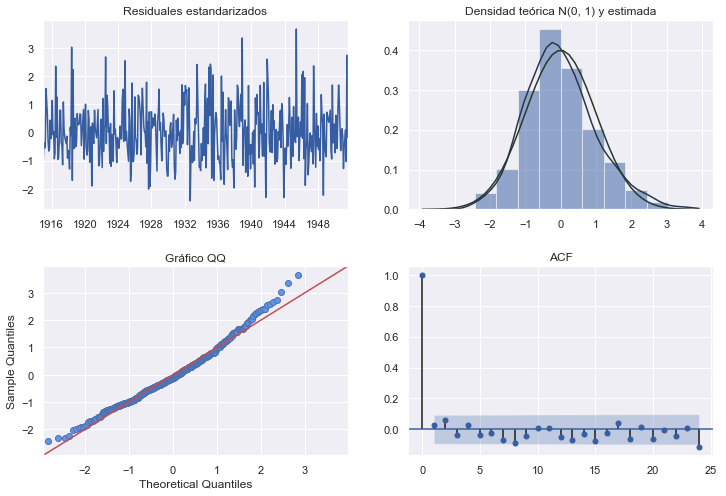

In [117]:
resid_diag(sarima11_resid)
plt.show()

In [118]:
print(sarima11_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(1, 0, 2)x(2, 0, 0, 12)   Log Likelihood                 482.315
Date:                            Thu, 04 Jul 2019   AIC                           -952.630
Time:                                    18:45:47   BIC                           -927.948
Sample:                                01-01-1914   HQIC                          -942.903
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.002    505.130      0.000       0.995       1.003
ma.L1         -0.3539      0.043   

In [119]:
print("SARIMA (1, 0, 2) x (3, 0, 0)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima11_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima11_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima11_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima11_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima11_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima11_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima11_box_forecasted)))

SARIMA (1, 0, 2) x (3, 0, 0)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -952.6298121517603
Test de Jarque-Bera (p-valor): 9.727564739286202e-06
Test de Ljung-Box para k =  6 (p-valor): 0.5646576512181141
Test de Ljung-Box para k = 12 (p-valor): 0.3835095315373295

RMSE (test): 28.661457482477648
MAE (test):  16.488395863188817
sMAPE (test):  35.81959586469082


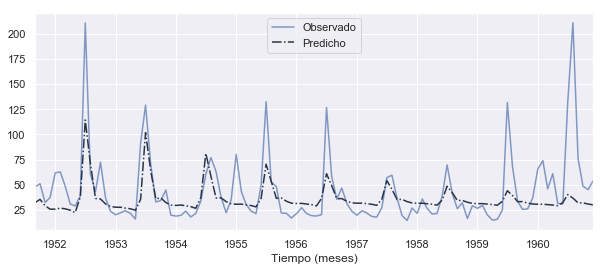

In [120]:
forecast_plot(test, sarima11_box_forecasted)
plt.show()

**SARIMA (3, 1, 0) x (2, 0, 0)<sub>12</sub>**

In [121]:
sarima12 = SARIMAX(bc_train, order = (3, 1, 0), seasonal_order = (2, 0, 0, 12))
sarima12_model = sarima12.fit()

sarima12_aic = sarima12_model.aic
sarima12_fitted = sarima12_model.fittedvalues
sarima12_resid = (sarima12_model.resid[12:] - 
                  sarima12_model.resid[12:].mean()) / sarima12_model.resid[12:].std()
sarima12_jb_test = jb(sarima12_resid)
sarima12_lb_test = lb(sarima12_resid)

sarima12_forecasted = sarima12_model.predict(split_date, end_date)
sarima12_box_forecasted = (bc_param * sarima12_forecasted + 1) ** (1 / bc_param)

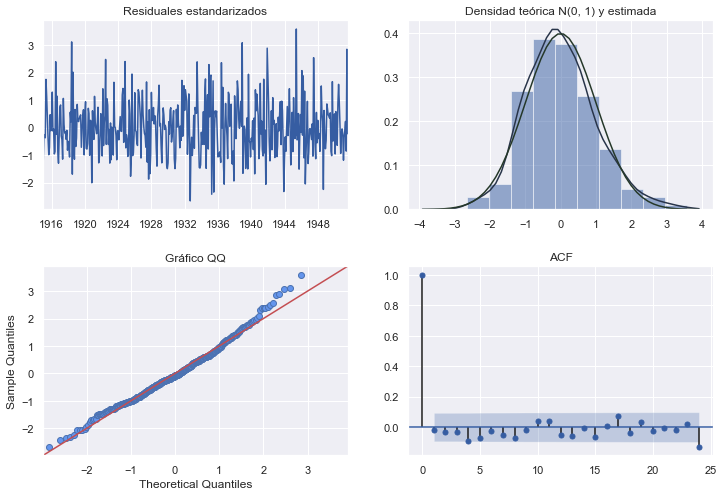

In [122]:
resid_diag(sarima12_resid)
plt.show()

In [123]:
print(sarima12_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 12)   Log Likelihood                 478.387
Date:                            Thu, 04 Jul 2019   AIC                           -944.773
Time:                                    18:45:49   BIC                           -920.104
Sample:                                01-01-1914   HQIC                          -935.051
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2784      0.047     -5.892      0.000      -0.371      -0.186
ar.L2         -0.2951      0.046   

In [124]:
print("SARIMA (3, 1, 0) x (3, 0, 0)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima12_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima12_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(sarima12_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(sarima12_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima12_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima12_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima12_box_forecasted)))

SARIMA (3, 1, 0) x (3, 0, 0)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -944.7731123922366
Test de Jarque-Bera (p-valor): 0.0002618782499241982
Test de Ljung-Box para k =  6 (p-valor): 0.24156163398839642
Test de Ljung-Box para k = 12 (p-valor): 0.2557396125217794

RMSE (test): 30.131423011307717
MAE (test):  24.87668745101635
sMAPE (test):  53.169159504076674


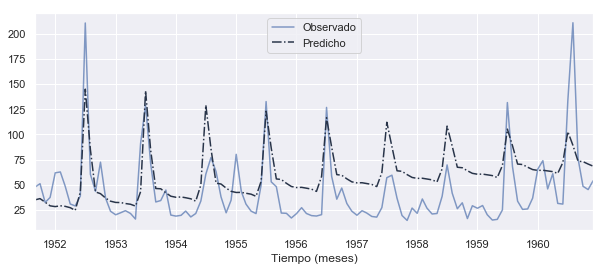

In [125]:
forecast_plot(test, sarima12_box_forecasted)
plt.show()

**SARIMA (2, 1, 2) x (2, 0, 0)<sub>12</sub>**

In [126]:
sarima13 = SARIMAX(bc_train, order = (2, 1, 2), seasonal_order = (2, 0, 0, 12))
sarima13_model = sarima13.fit()

sarima13_aic = sarima13_model.aic
sarima13_fitted = sarima13_model.fittedvalues
sarima13_resid = (sarima13_model.resid[12:] - 
                  sarima13_model.resid[12:].mean()) / sarima13_model.resid[12:].std()
sarima13_jb_test = jb(sarima13_resid)
sarima13_lb_test = lb(sarima13_resid)

sarima13_forecasted = sarima13_model.predict(split_date, end_date)
sarima13_box_forecasted = (bc_param * sarima13_forecasted + 1) ** (1 / bc_param)

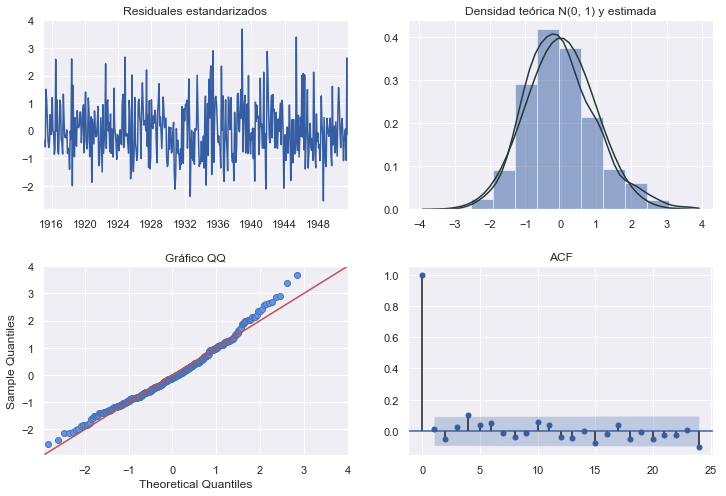

In [127]:
resid_diag(sarima13_resid)
plt.show()

In [128]:
print(sarima13_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(2, 1, 2)x(2, 0, 0, 12)   Log Likelihood                 497.181
Date:                            Thu, 04 Jul 2019   AIC                           -980.363
Time:                                    18:45:52   BIC                           -951.582
Sample:                                01-01-1914   HQIC                          -969.020
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3731      0.073     -5.104      0.000      -0.516      -0.230
ar.L2          0.5758      0.059   

In [129]:
print("SARIMA (2, 1, 2) x (2, 0, 0)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima9_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima13_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(sarima13_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(sarima13_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima13_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima13_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima13_box_forecasted)))

SARIMA (2, 1, 2) x (2, 0, 0)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -902.7066634500046
Test de Jarque-Bera (p-valor): 2.416370941312278e-06
Test de Ljung-Box para k =  6 (p-valor): 0.34316962540957
Test de Ljung-Box para k = 12 (p-valor): 0.48554474723781593

RMSE (test): 28.209171874266634
MAE (test):  16.694862572380313
sMAPE (test):  36.412646030162946


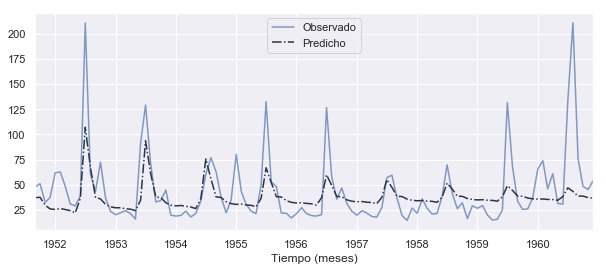

In [130]:
forecast_plot(test, sarima13_box_forecasted)
plt.show()

##### Autoarima

In [131]:
auto = auto_arima(bc_train, m = 12, seasonal = True)
auto

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 0, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [132]:
autosarima2 = SARIMAX(bc_train, order = (2, 1, 2), seasonal_order = (2, 0, 2, 12))
autosarima2_model = autosarima2.fit()

autosarima2_aic = autosarima2_model.aic
autosarima2_fitted = autosarima2_model.fittedvalues
autosarima2_resid = (autosarima2_model.resid[12:] - 
                     autosarima2_model.resid[12:].mean()) / autosarima2_model.resid[12:].std()
autosarima2_jb_test = jb(autosarima2_resid)
autosarima2_lb_test = lb(autosarima2_resid)

autosarima2_forecasted = autosarima2_model.predict(split_date, end_date)
autosarima2_box_forecasted = (bc_param * autosarima2_forecasted + 1) ** (1 / bc_param)

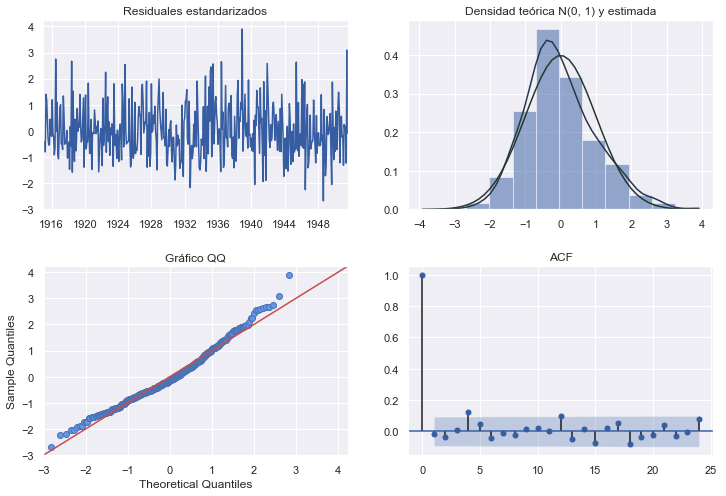

In [133]:
resid_diag(autosarima2_resid)
plt.savefig("resid_best.png", dpi=400)
plt.show()

In [134]:
print(autosarima2_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 508.362
Date:                            Thu, 04 Jul 2019   AIC                           -998.724
Time:                                    18:47:08   BIC                           -961.721
Sample:                                01-01-1914   HQIC                          -984.141
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0699     16.423      0.004      0.997     -32.118      32.258
ar.L2          0.2944      9.546   

In [135]:
print("SARIMA (2, 1, 2) x (2, 0, 0)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(autosarima2_aic))
print("Test de Jarque-Bera (p-valor): " + str(autosarima2_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(autosarima2_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(autosarima2_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, autosarima2_box_forecasted))))
print("MAE (test):  " + str(mae(test, autosarima2_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, autosarima2_box_forecasted)))

SARIMA (2, 1, 2) x (2, 0, 0)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -998.7244026526776
Test de Jarque-Bera (p-valor): 1.925192263208415e-06
Test de Ljung-Box para k =  6 (p-valor): 0.21515469923533817
Test de Ljung-Box para k = 12 (p-valor): 0.2760923446894693

RMSE (test): 29.9846699649396
MAE (test):  16.04973322417936
sMAPE (test):  33.00127011320319


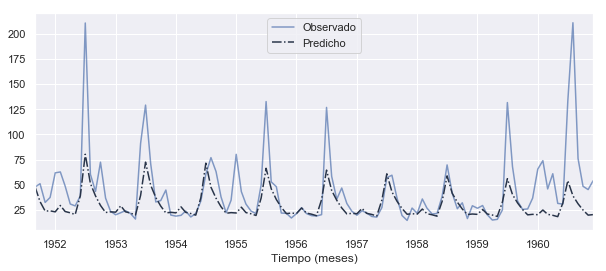

In [136]:
forecast_plot(test, autosarima2_box_forecasted)
plt.show()

- **SARIMA (2, 1, 2) x (2, 0, 1)<sub>12</sub>**

In [137]:
sarima14 = SARIMAX(bc_train, order = (2, 1, 2), seasonal_order = (2, 0, 1, 12))
sarima14_model = sarima14.fit()

sarima14_aic = sarima14_model.aic
sarima14_fitted = sarima14_model.fittedvalues
sarima14_resid = (sarima14_model.resid[12:] -
                  sarima14_model.resid[12:].mean()) / sarima14_model.resid[12:].std()
sarima14_jb_test = jb(sarima14_resid)
sarima14_lb_test = lb(sarima14_resid)

sarima14_forecasted = sarima14_model.predict(split_date, end_date)
sarima14_box_forecasted = (bc_param * sarima14_forecasted + 1) ** (1 / bc_param)

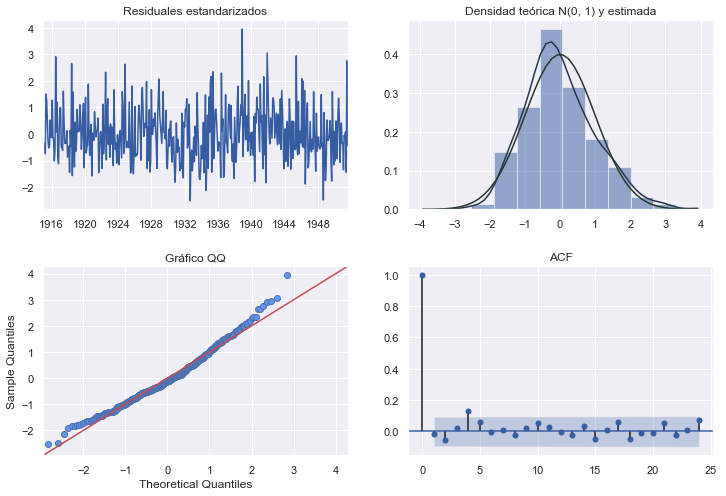

In [142]:
resid_diag(sarima14_resid)
plt.savefig("resid_best.png", dpi=400)
plt.show()

In [139]:
print(sarima14_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  452
Model:             SARIMAX(2, 1, 2)x(2, 0, 1, 12)   Log Likelihood                 511.934
Date:                            Thu, 04 Jul 2019   AIC                          -1007.869
Time:                                    18:47:13   BIC                           -974.977
Sample:                                01-01-1914   HQIC                          -994.906
                                     - 08-01-1951                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.050     -7.386      0.000      -0.467      -0.271
ar.L2          0.6247      0.041   

In [140]:
print("SARIMA (2, 1, 2) x (2, 0, 1)")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("AIC: " + str(sarima14_aic))
print("Test de Jarque-Bera (p-valor): " + str(sarima14_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(sarima14_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(sarima14_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, sarima14_box_forecasted))))
print("MAE (test):  " + str(mae(test, sarima14_box_forecasted)))
print("sMAPE (test):  " + str(smape(test, sarima14_box_forecasted)))

SARIMA (2, 1, 2) x (2, 0, 1)

Observaciones ajustadas: 452
Observaciones predichas: 112

AIC: -1007.8686734324268
Test de Jarque-Bera (p-valor): 2.8743969410190724e-06
Test de Ljung-Box para k =  6 (p-valor): 0.15446746927782673
Test de Ljung-Box para k = 12 (p-valor): 0.45015879016303895

RMSE (test): 24.823649386547004
MAE (test):  15.352171959400692
sMAPE (test):  33.52102774477333


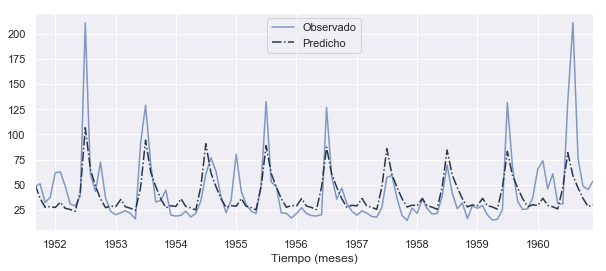

In [141]:
forecast_plot(test, sarima14_box_forecasted)
plt.show()